In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Création du jeu de données

On va créer des données avec une structure particulière.

### Rangement des images par label

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
test_images_tf, test_labels_tf=tf.constant(test_images,tf.float32),tf.constant(test_labels,tf.float32)
train_images_tf, train_labels_tf=tf.constant(train_images,tf.float32),tf.constant(train_labels,tf.float32)

In [4]:
def preprocess(images,labels):
    images_bin=tf.cast((images>125),tf.float32)
    dico={}
    for i in range(10):
        dico[i]=images_bin[labels==i]
    return dico

In [5]:
DICO_TEST=preprocess(test_images_tf,test_labels_tf)
DICO_TRAIN=preprocess(train_images_tf,train_labels_tf)

***A vous:***
* Qu'y a-t-il dans  `DICO_TEST[3]`? Est-ce que les différents tenseurs `DICO_TRAIN[i]` on la même shape?
* Savez-vous pourquoi j'ai mis les variables `DICO_TEST` et `DICO_Train` en lettres majuscures ; c'est une convention assez classique, vous pouvez la déduire en regardant la structure du programme.

ººuntil:-red> Répondre ici.

* Toutes les images de 3. Non
* Car ces des variables globales


### Le distributeur de données

In [6]:
def make_XY(dico,batch_size,add_one=True):
    X=[]
    Y=[]
    for i in range(batch_size):
        j=np.random.randint(10)
        imgs=dico[j]
        nb_imgs=imgs.shape[0]
        indices_selected=np.random.randint(0, nb_imgs, size=np.random.randint(5,13))

        x=tf.gather(imgs,indices_selected)
        if add_one:
            x+=1
        mask=tf.cast(tf.random.uniform(shape=x.shape)>0.95,tf.float32)
        x=x*mask
        X.append(x)

        Y.append(j)

    return X,Y

Testons

In [7]:
X,Y=make_XY(DICO_TEST,8)

In [8]:
for x,y in zip(X,Y):
    print(x.shape,y)

(5, 28, 28) 9
(7, 28, 28) 0
(5, 28, 28) 5
(6, 28, 28) 4
(10, 28, 28) 4
(12, 28, 28) 3
(10, 28, 28) 4
(11, 28, 28) 3


### Visualisation et explication

In [ ]:
def plot_XY(X,Y):
    nb_i=len(X)
    nb_j=max([x.shape[0] for x in X])
    fig,axs=plt.subplots(nb_i,nb_j,figsize=(nb_j,nb_i))
    for i in range(nb_i):
        for j in range(nb_j):
            axs[i,j].axis("off")

    for i in range(nb_i):
        x=X[i]
        for j in range(x.shape[0]):
            axs[i,j].set_title(f"{Y[i]}")
            axs[i,j].imshow(x[j,:,:],vmin=0,vmax=2)
    fig.tight_layout()

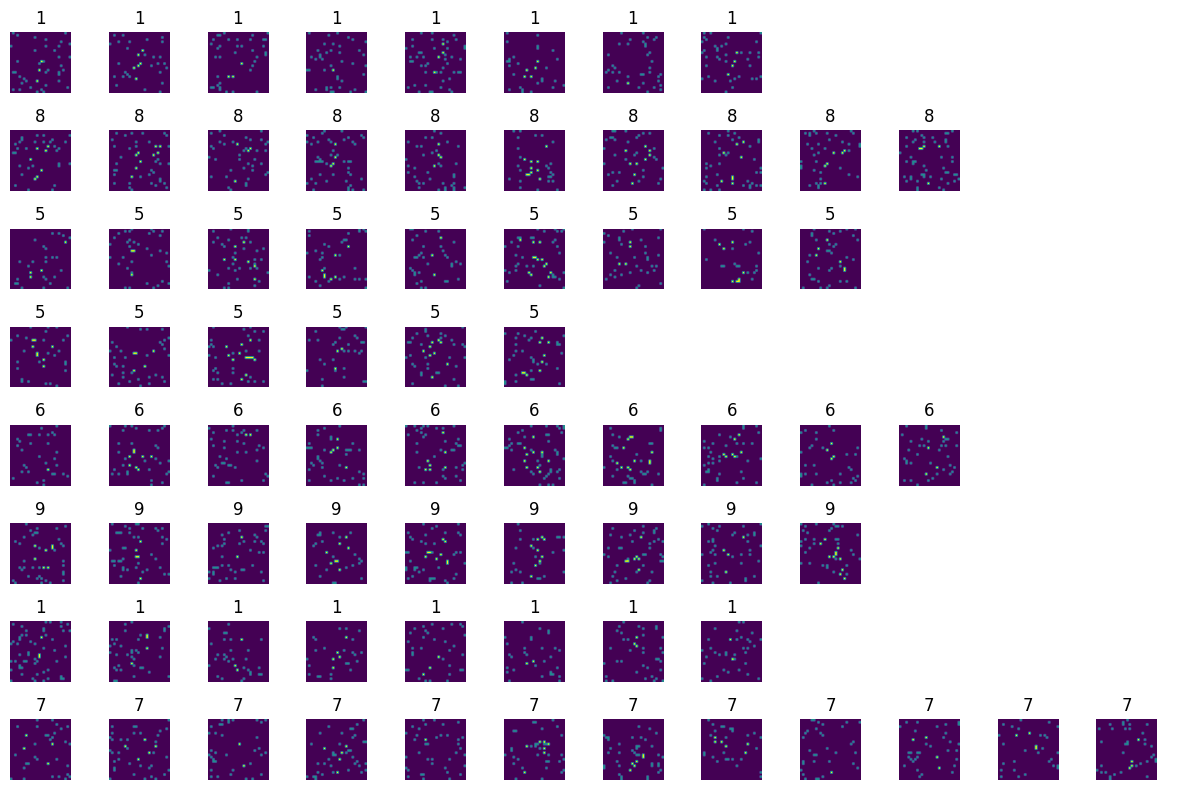

In [ ]:
plot_XY(X,Y)

* Une donnée d'entrée $x$ c'est un ensemble d'images détériorées, tous du même chiffre.
Cet ensemble n'est pas ordonné et il est de taille variable (comme la plupart des ensemble dans le domaine de "l'apprentissage d'ensemble").

* Une donnée de sortie $y$ le chiffre correspondant à $x$.

* Un batch $X$ c'est un ensemble de données $x$ (ne provenant pas tous du même chiffre).

***A vous:*** Dans `make_XY`:

* Si l'on met `add_one=False`, est-ce que les données sont plus facile ou plus difficile à analyser? Justifiez.
* Il y a une constante très importante qui gére la détérioration des données. C'est laquelle?
* Modifier  `make_XY` pour que cette constante que l'on appélera `deterioration_rate` apparaissent dans la signature de la fonction, qui déviendra donc:  

        def make_XY(dico,batch_size,add_one=True,deterioration_rate=...)


Remarque: si cette constante vaut 0, les images ne sont pas du tout détériorées. A l'inverse, si elle vaut 1, les images ne sont plus du tout reconnaissables.

ººuntil:-red> Répondre ici.

## Trainer

In [9]:
from IPython.display import clear_output

***A vous:*** Dans le trainer ci-dessous. A quoi sert
* la fonction `clear_output`?
* Le bloc `try-except`?
* Que signifie la constante `1e-4` dans `Adam(1e-4)`? Si on écrit simplement `Adam()` qu'est-ce qui se passe?  

ººuntil:-red> Répondre ici



***A vous:***  Pourquoi est-ce qu'on a un attribut `self.val_steps` et pas d'attribut `self.train_steps`? Et d'ailleurs, le `trainer` a un petit défaut: Imaginez qu'on lance une première fois la méthode `trainer.train()`. On intérromp l'entrainement. Puis on le reprend en relançant `trainer.train()`. Les graphiques qui apparaissent alors sont moche (cf. capture d'écran ci-dessous, on voit des points oranges sur 2 étages). Corriger ce défaut.

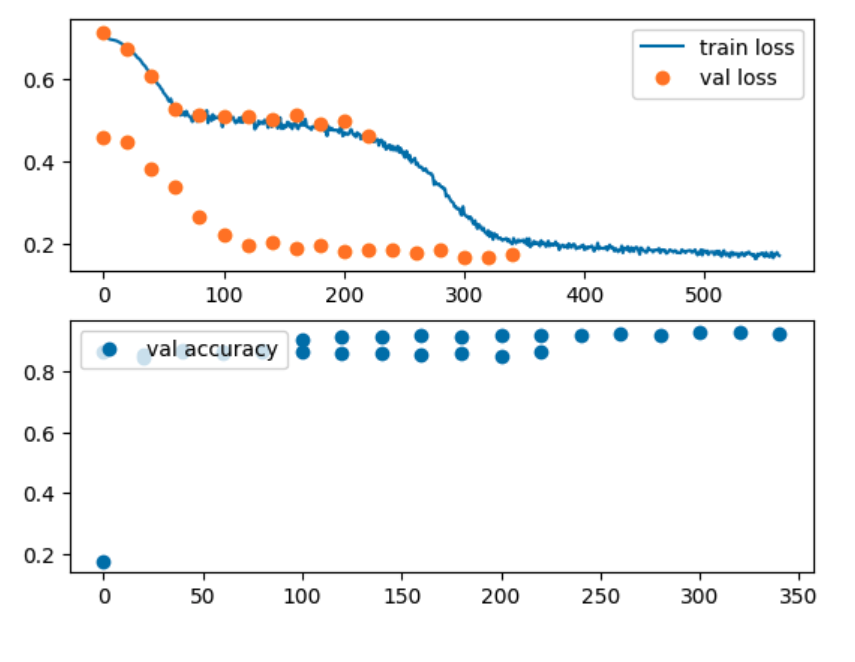

In [ ]:
class Trainer:

    def __init__(self,model):

        self.batch_size=64

        self.model=model
        self.optimizer=tf.keras.optimizers.Adam(1e-4)

        self.losses=[]
        self.val_losses=[]
        self.val_accuracies=[]
        self.val_steps=[]


    def make_XY_train(self):
        return make_XY(DICO_TRAIN,self.batch_size)
    def make_XY_test(self):
        return make_XY(DICO_TEST,30)

    def train_step(self,X,Y):
        with tf.GradientTape() as tape:
            Y_pred=self.model(X)
            loss=tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(Y,Y_pred))
            tv=self.model.trainable_variables
            grad=tape.gradient(loss,tv)
            self.optimizer.apply_gradients(zip(grad,tv))
        return loss

    def val_step(self,X,Y):
        Y_pred=self.model(X)
        loss=tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(Y,Y_pred))
        acc=tf.reduce_mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(Y,Y_pred))
        return loss,acc

    def train(self):
        try:
            for i in range(1_000):
                X,Y=self.make_XY_train()
                loss=self.train_step(X,Y)
                self.losses.append(loss)

                if i%20==0:
                    clear_output(wait=True)
                    X,Y=self.make_XY_test()
                    val_loss,val_acc=self.val_step(X,Y)
                    self.val_losses.append(val_loss)
                    self.val_accuracies.append(val_acc)
                    self.val_steps.append(i)
                    fig,(ax0,ax1)=plt.subplots(2,1)
                    ax0.plot(self.losses,label="train loss")
                    ax0.plot(self.val_steps,self.val_losses,"o",label="val loss")
                    ax1.plot(self.val_steps,self.val_accuracies,"o",label='val accuracy')
                    ax0.legend(loc="upper right")
                    ax1.legend(loc="upper left")
                    plt.show()
        except KeyboardInterrupt:
            pass

## Des modèles

### Un premier modèle pas terrible

***A vous:***
* Dans la méthode `call` de la classe `ABlock`, l'opération `+` est la caractérisitque d'une technique de Deeplearning très employée. Comment d'appelle-t-elle.

* Le modèle le passe pas le premier test. C'est justement dû à l'opération `+` dont on parlait avant. Pour que cela fonctionne il faut ajouter 2 lignes de code ci-dessous. Ces 2 lignes permettent de définir puis d'appliquer un layer très simple qui permet de faire une sorte de premier traitement des données.


Si vous n'avez pas réussi à faire fonctionner le modèle, vous pouvez quand même faire la suite.

In [ ]:
class ABlock(tf.keras.Model):
    def __init__(self,units):
        super().__init__()
        self.dense=tf.keras.layers.Dense(units,activation="tanh")
        self.norm=tf.keras.layers.LayerNormalization()

    def call(self,x):
        h=self.dense(x)
        return self.norm(x+h)


class SimpleModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        dim_before=64
        #ºnext:-> Il manque une ligne ici
        self.to_dim_before=tf.keras.layers.Dense(dim_before)
        self.blocks_before=[ABlock(dim_before) for _ in range(2)]

        self.blocks_after=[tf.keras.layers.Dense(dim,activation="tanh") for dim in [64,32,16]]
        self.last_layer=tf.keras.layers.Dense(10,activation="softmax")


    @tf.function(input_signature=(tf.TensorSpec(shape=[None,28,28], dtype=tf.float32),))
    def call_one_elem(self,x):
        print("traçage de call_one_elem")
        A=tf.reshape(x,[-1,28*28])
        #ºnext:-> Il manque une ligne ici
        A=self.to_dim_before(A) #(n,dim_model)

        for block in self.blocks_before:
            A=block(A)

        B=tf.reduce_max(A,axis=0) #(dim_model)

        return B


    def call(self,X):
        C=[]
        for x in X:
            C.append(self.call_one_elem(x))
        C=tf.stack(C,axis=0) #(b,dim_model)

        for block in self.blocks_after:
            C=block(C) #(b,dim_decreasing)

        return self.last_layer(C) #(b,10)


def test_model():
    model=SimpleModel()
    Y=model(X)
    print(Y.shape)
test_model()

traçage de call_one_elem
traçage de call_one_elem
(8, 10)


Remarque: le décorateur `@tf.function` permet d'accélérer la méthode `call_one_elem(self,x)`. La méthode sera "tracée" (=graver en un graphe de calcul très rapide).

 Mais dans notre cas l'argument `x` de la méthode  `call_one_elem` est un tenseur qui n'a pas toujours la même shape d'un appel à l'autre. Tensorflow procéderait alors à un retraçage à chaque fois que la shape changerait. Et chaque traçage est long.

 Pour éviter cela, on a indiquer la shape de l'argument avec `shape=[None,28,28]`, ce qui indique que la première dimension de l'argument est de taille variable.

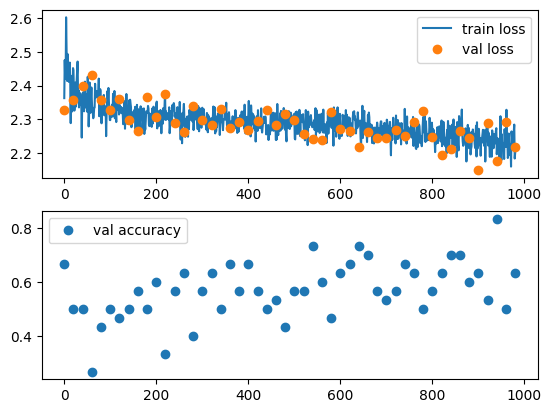

In [ ]:
trainer=Trainer(SimpleModel())
trainer.train()

Avec ce modèle "inadapté" aux images, en 1000 trainstep, avec un `deterioration_rate` de 80%, sur ma session,  cela a convergé ainsi.  

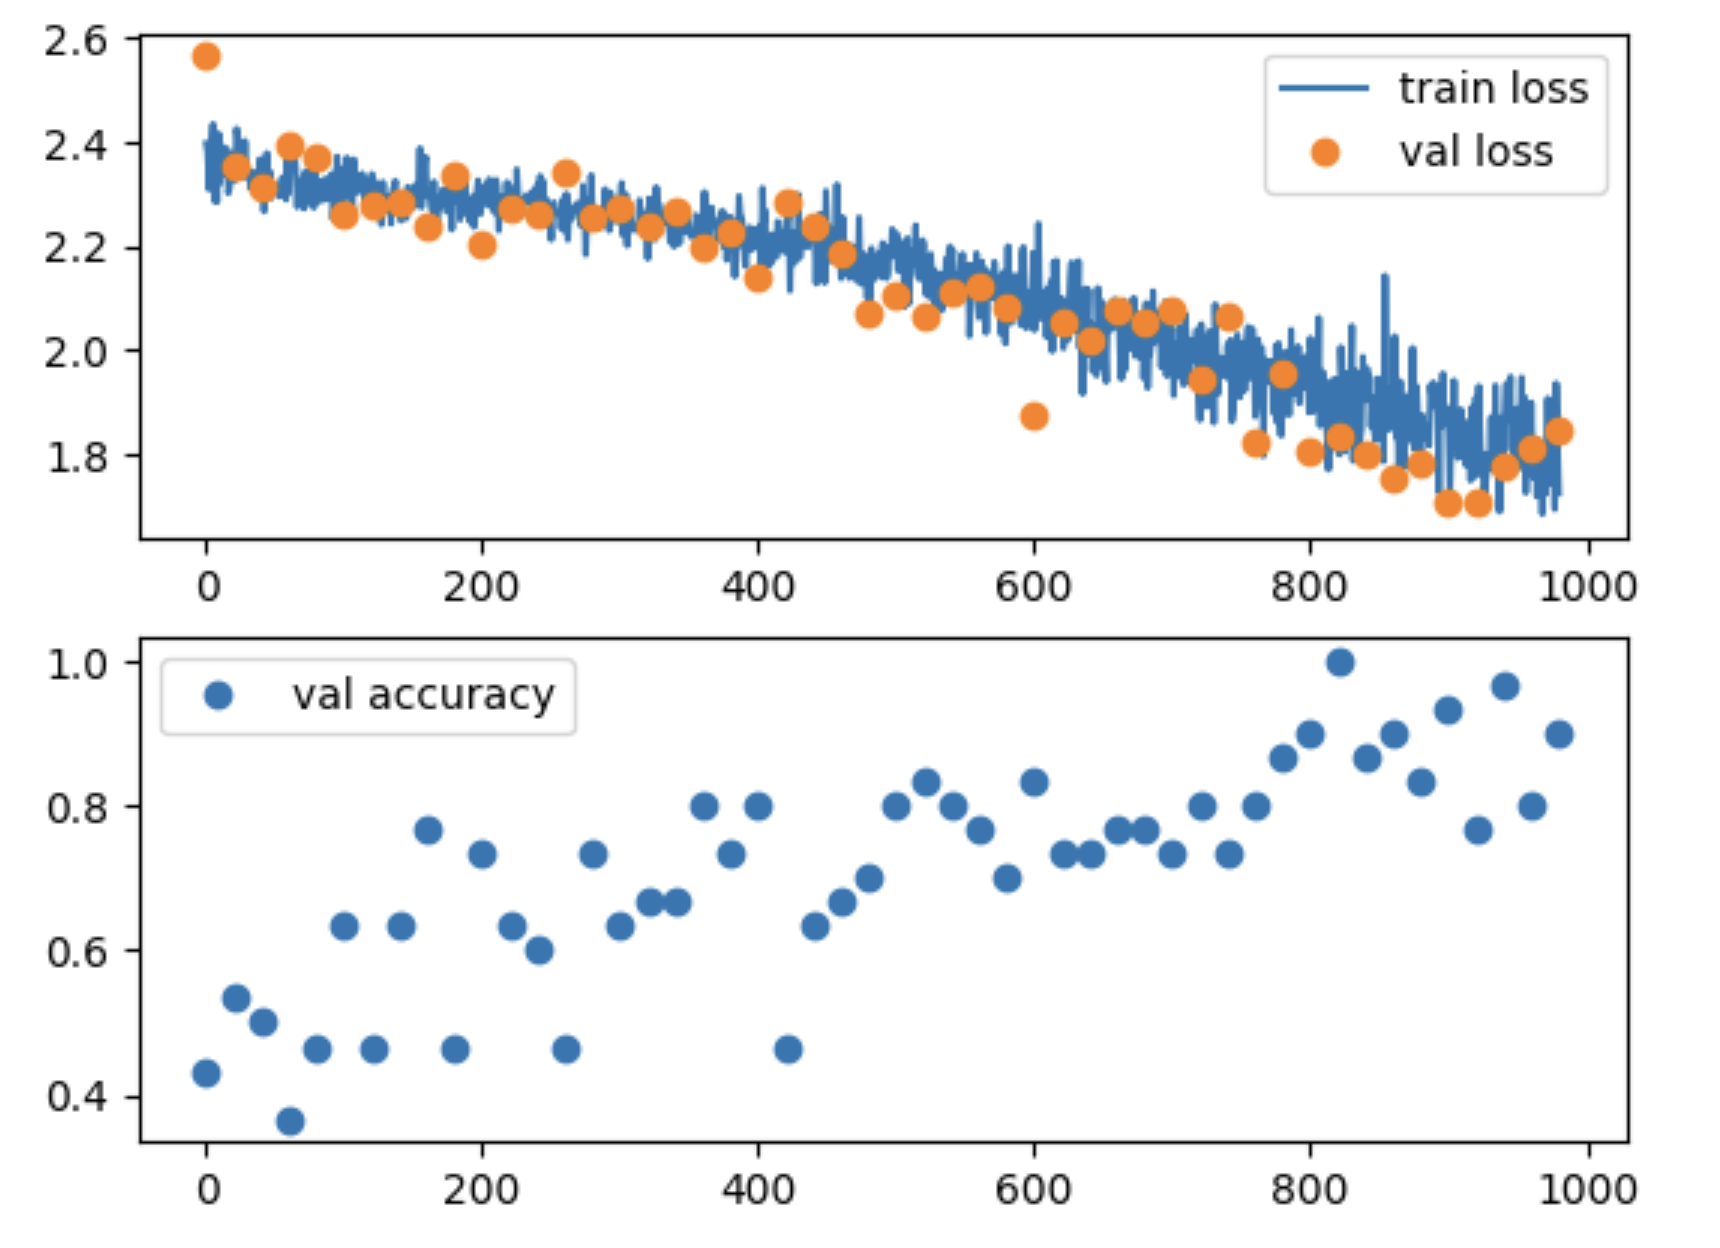

Voici comment on peut utiliser le modèle une fois entrainé.

In [10]:
X,Y=trainer.make_XY_test()
Y_pred=trainer.model(X)

NameError: ignored

In [11]:
print(np.array(Y))
print(tf.argmax(Y_pred,axis=1).numpy())

[9 0 5 4 4 3 4 3]


NameError: ignored

***A vous:***
* A quoi sert le `tf.argmax`?
* Recalculer l'accuracy en utilisant simplement numpy à partir des données générée par les lignes de code ci-dessus.


### Un meilleur modèle

In [ ]:
class ConvBlock(tf.keras.Model):
    def __init__(self,dim1,dim2):
        super().__init__()
        self.conv1=tf.keras.layers.Conv2D(dim1,(3,3),activation="relu",padding="same")
        self.conv2=tf.keras.layers.Conv2D(dim2,(3,3),activation="relu",padding="same")
        self.pool=tf.keras.layers.MaxPool2D()

    def call(self,X):
        A=self.conv2(self.conv1(X))
        return self.pool(A)


class ConvModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.increasing_dim=(16,32,64)
        self.decreasing_dim=(64,32,16)
        self.blocks_before=[tf.keras.layers.Conv2D(dim,(3,3),activation="relu",padding="same") for dim in self.increasing_dim]
        self.blocks_after=[ConvBlock(64,32),ConvBlock(32,16)]

        self.last_layer=tf.keras.layers.Dense(10,activation="softmax")


    @tf.function(input_signature=(tf.TensorSpec(shape=[None,28,28], dtype=tf.float32),))
    def call_one_elem(self,x):
        print("traçage de call_one_elem")
        A=tf.reshape(x,[-1,28,28,1])
        for block in self.blocks_before:
            A=block(A) #(n,28,28,increasing_dim)

        B=tf.reduce_max(A,axis=0) #(28,28,increasing_dim[-1])

        return B


    #ºuntil:
    def call(self,X):
        batch_size=len(X)
        C=[]
        for x in X:
            C.append(self.call_one_elem(x))
        C=tf.stack(C,axis=0) #(b,28,28,last_dim)

        for block in self.blocks_after:
            C=block(C) #(b,28/2^i,28/2^i,decreasing_dim)

        D=tf.reshape(C,[batch_size,-1])

        return self.last_layer(D) #(b,10)


def test_model():
    model=ConvModel()
    Y=model(X)
    print(Y.shape)
test_model()

NameError: ignored

***A vous:*** Est-ce que le modèle fonctionne encore en utilisant des convolutions en  supprimant l'option `padding="same"`. Pour justifier, vous pourrez indiquer les différentes shape générée sans cette option.

***A vous:*** Ecrire la méthode `call` du modèle. Elle doit bien sur appeler plusieur fois la méthode `call_one_elem`.

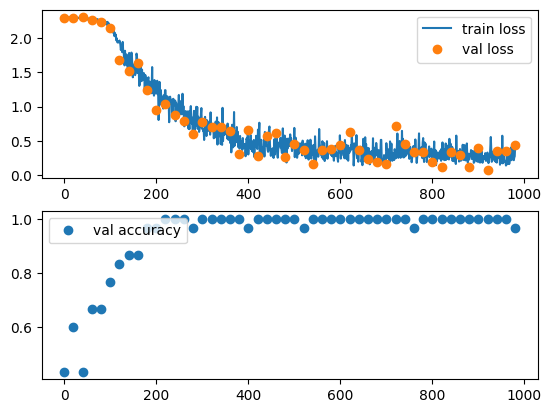

In [ ]:
trainer=Trainer(ConvModel())
trainer.train()

Voici ce que l'on obtient avec le modèle de convolution, avec un `deterioration_rate` de 95%

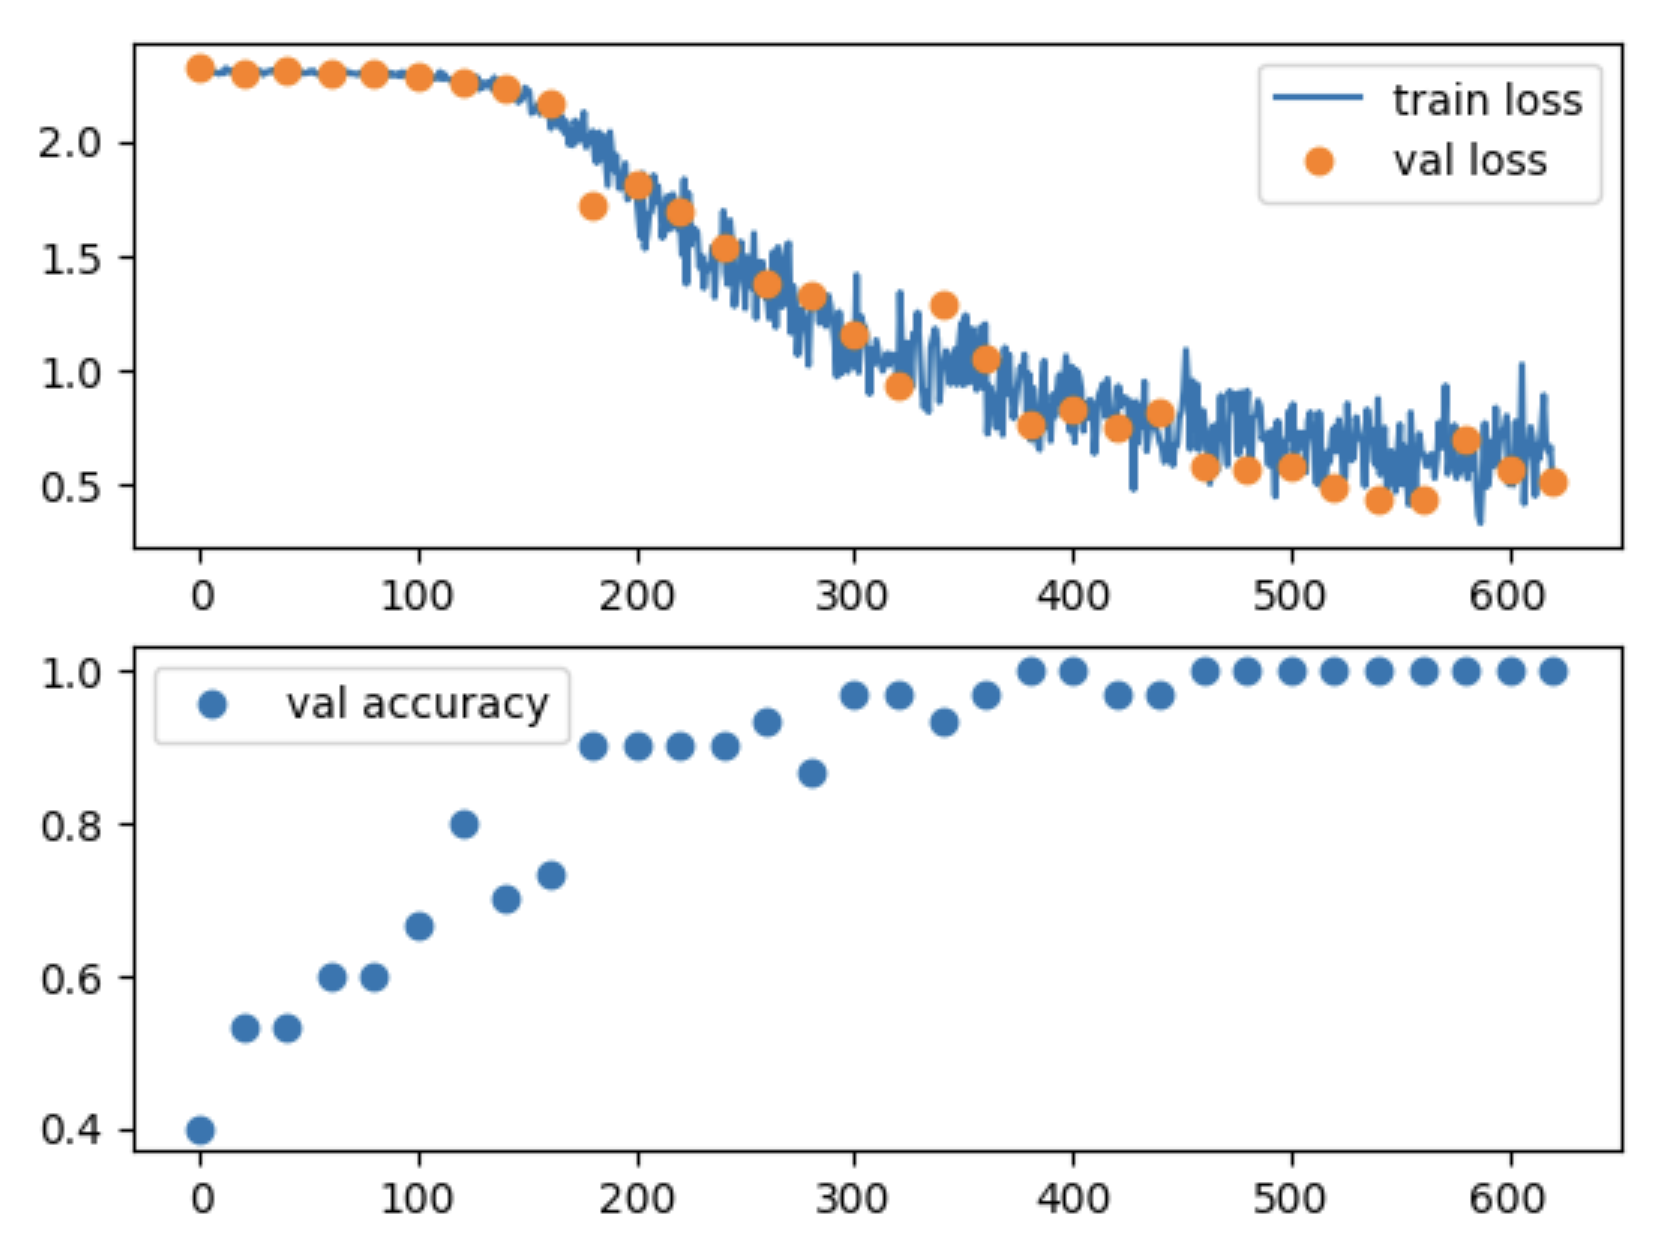

***A vous:*** Essayez des `deterioration_rate` encore plus grand. N'hésitez pas à modifier l'architecture du réseau de neurone.

## Reconstruction des images

Changeons de données.

### Le distributeur de données

In [13]:
def make_XY2(dico,batch_size,add_one=True):
    X=[]
    Y=[]
    for i in range(batch_size):
        j=np.random.randint(10)
        imgs=dico[j]
        nb_imgs=imgs.shape[0]
        indices_selected=np.random.randint(0, nb_imgs, size=np.random.randint(5,13))

        x=tf.gather(imgs,indices_selected)
        y=x*1 #pour faire une copie

        if add_one:#uniquement pour x
            x+=1


        mask=tf.cast(tf.random.uniform(shape=x.shape)>0.8,tf.float32)
        x=x*mask
        X.append(x)
        Y.append(y)
    return X,Y

Testons

In [14]:
X,Y=make_XY2(DICO_TEST,8)

In [15]:
for x,y in zip(X,Y):
    print(x.shape,y.shape)

(6, 28, 28) (6, 28, 28)
(5, 28, 28) (5, 28, 28)
(6, 28, 28) (6, 28, 28)
(11, 28, 28) (11, 28, 28)
(11, 28, 28) (11, 28, 28)
(10, 28, 28) (10, 28, 28)
(10, 28, 28) (10, 28, 28)
(9, 28, 28) (9, 28, 28)


### Visualisation et explication

In [ ]:
def plot_XY2(X,Y):
    nb_i=len(X)
    nb_j=max([x.shape[0] for x in X])
    fig,axs=plt.subplots(nb_i*2,nb_j,figsize=(nb_j,nb_i*2))
    for i in range(nb_i*2):
        for j in range(nb_j):
            axs[i,j].axis("off")

    for i in range(nb_i):
        x=X[i]
        y=Y[i]
        for j in range(x.shape[0]):
            axs[2*i,j].imshow(x[j,:,:],vmin=0,vmax=2)
            axs[2*i+1,j].imshow(y[j,:,:],vmin=0,vmax=1)

    fig.tight_layout()

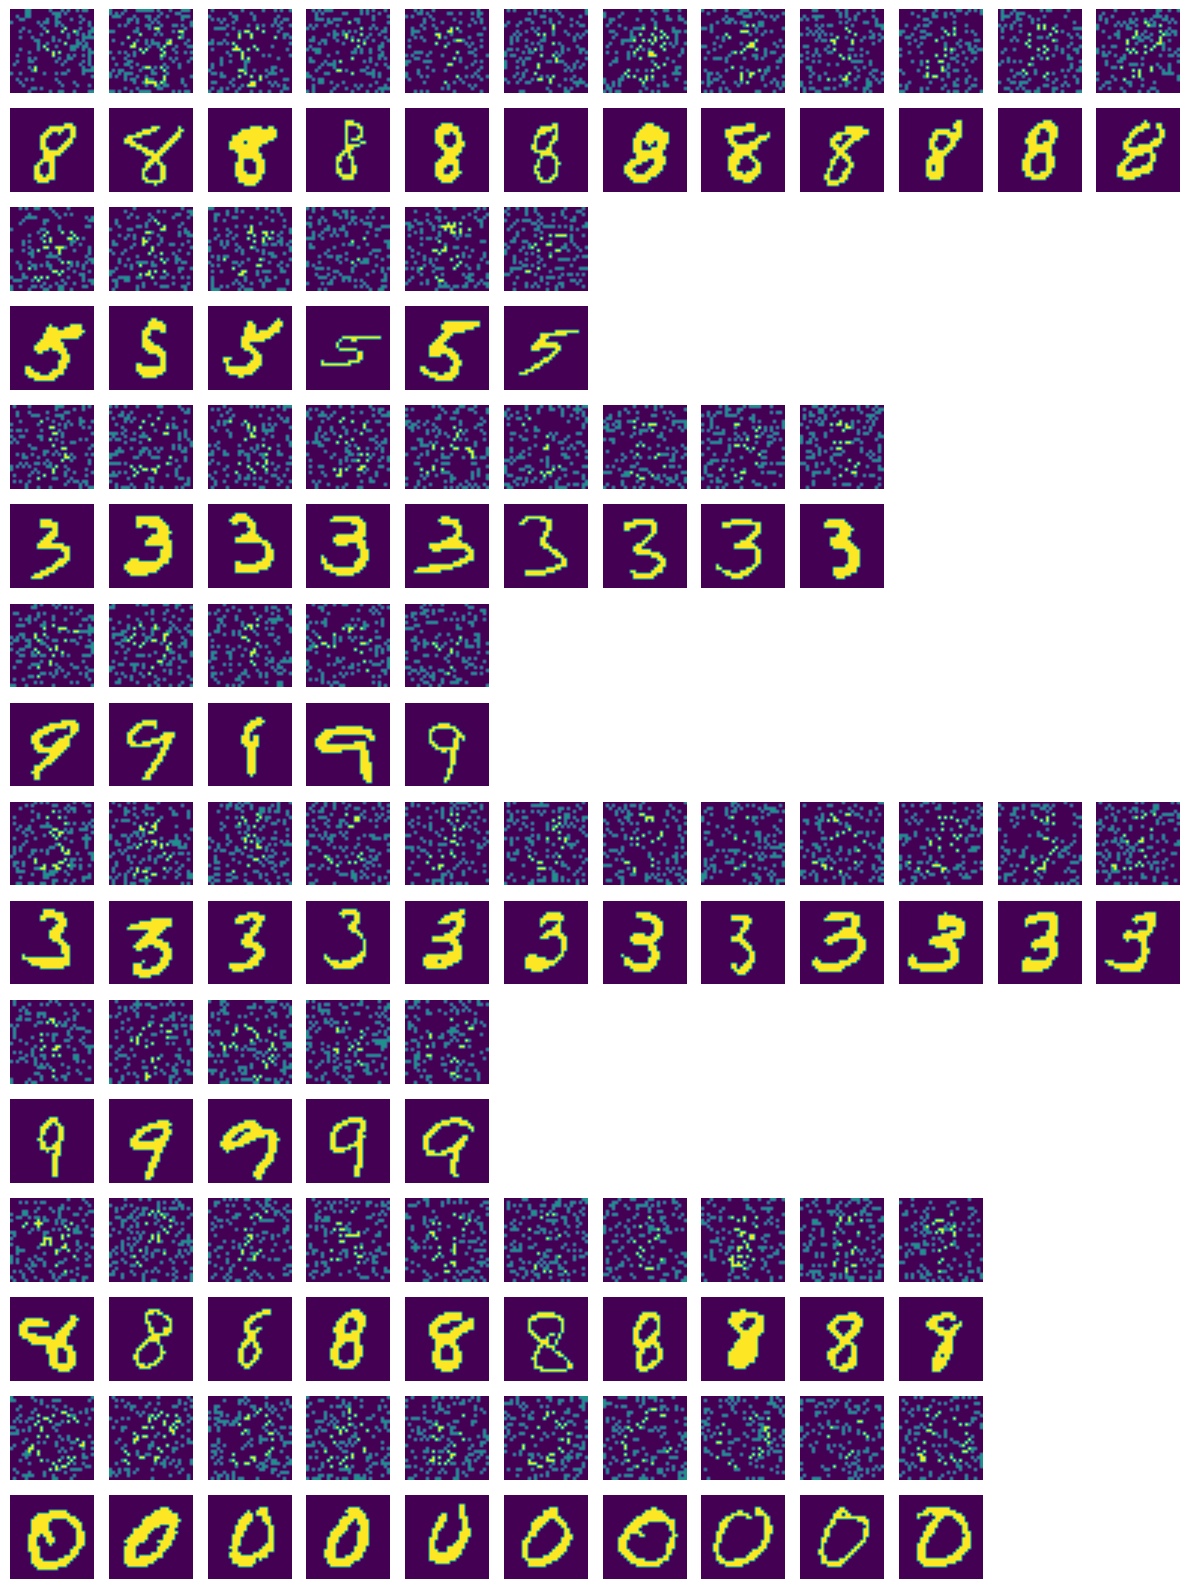

In [ ]:
plot_XY2(X,Y)

Notre tache maintenant est de retrouver les images. Voici un modèle qui fonctionne.


***A vous:***

* Ajouter de nouveau la fonction `call` qui a été effacée.  

* Testez-le.

* Essayez ensuite de le modifier pour qu'il accomplisse 2 taches en même temps: qu'il reconstruise l'image et qu'il renoie le label correspondant à l'image (le non chiffre).
* S'il vous reste du temps essayez d'améliorer les résultats en modifiant l'architecture (ex: augmenter le nombre de couche, leur taille, ou complètement changer la structure).

### Modèle

In [17]:
print(X[0].shape)

(6, 28, 28)


In [ ]:
class FilterBlock(tf.keras.Model):
    def __init__(self,global_feature:bool,dims):
        super().__init__()
        self.global_feature=global_feature
        self.blocks=[tf.keras.layers.Conv2D(dim,(3,3),activation="relu",padding="same") for dim in dims]

    def call(self,x):
        A=x #(n,28,28,dim_in)
        for block in self.blocks:
            A=block(A) #(n,28,28,dims[i])

        if self.global_feature:
            A=tf.reduce_max(A,axis=0) #(28,28,dims[-1])
        return A


class ConvModel2(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.last_dim=32
        self.global_feature_block=FilterBlock(True,[8,16,self.last_dim])
        self.individual_feature_block=FilterBlock(False,[8,16,self.last_dim])
        self.union_feature_block=FilterBlock(False,[32,16,8])
        self.last_layer=tf.keras.layers.Dense(1,activation="sigmoid")


    @tf.function(input_signature=(tf.TensorSpec(shape=[None,28,28], dtype=tf.float32),))
    def call_one_elem(self,x):
        print("traçage de call_one_elem")
        x=x[:,:,:,None] #(n,28,28,1)
        global_feat=self.global_feature_block(x) # [28,28,self.last_dim]
        individual_feat=self.individual_feature_block(x) #[n,28,28,self.last_dim]
        sum_feat=global_feat[None,:,:,:]+individual_feat #[n,28,28,self.last_dim]
        union_feat=self.union_feature_block(sum_feat) #[n,28,28,8]
        return self.last_layer(union_feat)[:,:,:,0] #[n,28,28]

    #ºuntil:
    def call(self,X):
        batch_size=len(X)
        res=[]
        for x in X:
            res.append(self.call_one_elem(x)) #[n,28,28]

        return res #[b,n,28,28] avec n variable


def test_model():
    model=ConvModel2()
    Y_pred=model(X)
    print([y.shape for y in Y])
test_model()

traçage de call_one_elem
traçage de call_one_elem
[TensorShape([12, 28, 28]), TensorShape([6, 28, 28]), TensorShape([9, 28, 28]), TensorShape([5, 28, 28]), TensorShape([12, 28, 28]), TensorShape([5, 28, 28]), TensorShape([10, 28, 28]), TensorShape([10, 28, 28])]


In [ ]:
def loss_for_list_fn(Y,Y_pred):
    res=tf.constant(0.)
    for y,y_pred in zip(Y,Y_pred):
        res+=tf.reduce_mean(tf.keras.losses.binary_crossentropy(y,y_pred))
    return res/len(Y)

def acc_for_list_fn(Y,Y_pred):
    res=tf.constant(0.)
    for y,y_pred in zip(Y,Y_pred):
        res+=tf.reduce_mean(tf.keras.metrics.binary_accuracy(y,y_pred))
    return res/len(Y)

def test():
    X,Y=make_XY2(DICO_TEST,5)
    model=ConvModel2()
    Y_pred=model(X)
    loss=loss_for_list_fn(Y,Y_pred)
    print(loss)
    loss=loss_for_list_fn(Y,Y)
    print(loss)
    print(acc_for_list_fn(Y,Y))
test()

traçage de call_one_elem
traçage de call_one_elem
tf.Tensor(0.68919986, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:
class Trainer2:

    def __init__(self,model):

        self.batch_size=64

        self.model=model
        self.optimizer=tf.keras.optimizers.Adam(1e-4)

        self.losses=[]
        self.val_losses=[]
        self.val_accuracies=[]
        self.val_steps=[]

    def make_XY_train(self):
        return make_XY2(DICO_TRAIN,self.batch_size)
    def make_XY_test(self):
        return make_XY2(DICO_TEST,30)

    def train_step(self,X,Y):
        with tf.GradientTape() as tape:
            Y_pred=self.model(X)
            loss=loss_for_list_fn(Y,Y_pred)
            tv=self.model.trainable_variables
            grad=tape.gradient(loss,tv)
            self.optimizer.apply_gradients(zip(grad,tv))
        return loss

    def val_step(self,X,Y):
        Y_pred=self.model(X)
        loss=loss_for_list_fn(Y,Y_pred)
        acc=acc_for_list_fn(Y,Y_pred)
        return loss,acc

    def train(self):
        try:
            for i in range(1_000):
                X,Y=self.make_XY_train()
                loss=self.train_step(X,Y)
                self.losses.append(loss)

                if i%20==0:
                    clear_output(wait=True)
                    X,Y=self.make_XY_test()
                    val_loss,val_acc=self.val_step(X,Y)
                    self.val_losses.append(val_loss)
                    self.val_accuracies.append(val_acc)
                    self.val_steps.append(i)
                    fig,(ax0,ax1)=plt.subplots(2,1)
                    ax0.plot(self.losses,label="train loss")
                    ax0.plot(self.val_steps,self.val_losses,"o",label="val loss")
                    ax1.plot(self.val_steps,self.val_accuracies,"o",label='val accuracy')
                    ax0.legend(loc="upper right")
                    ax1.legend(loc="upper left")
                    plt.show()
        except KeyboardInterrupt:
            pass

In [ ]:
trainer=Trainer2(ConvModel2())

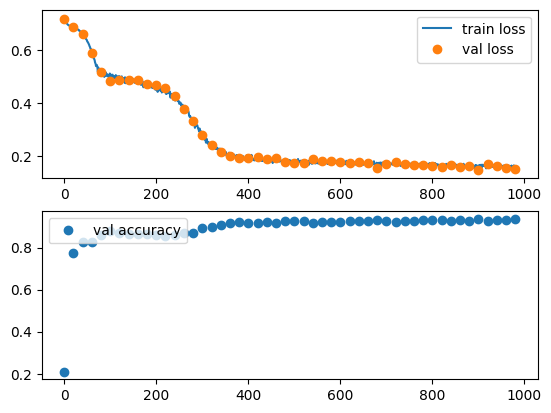

In [ ]:
trainer.train()

### Observons les résultats

En utilisant les code ci-dessous avec votre modèle entrainé, vous devrez obtenir des reconstructions semblables à celles-ci (ou mieux).

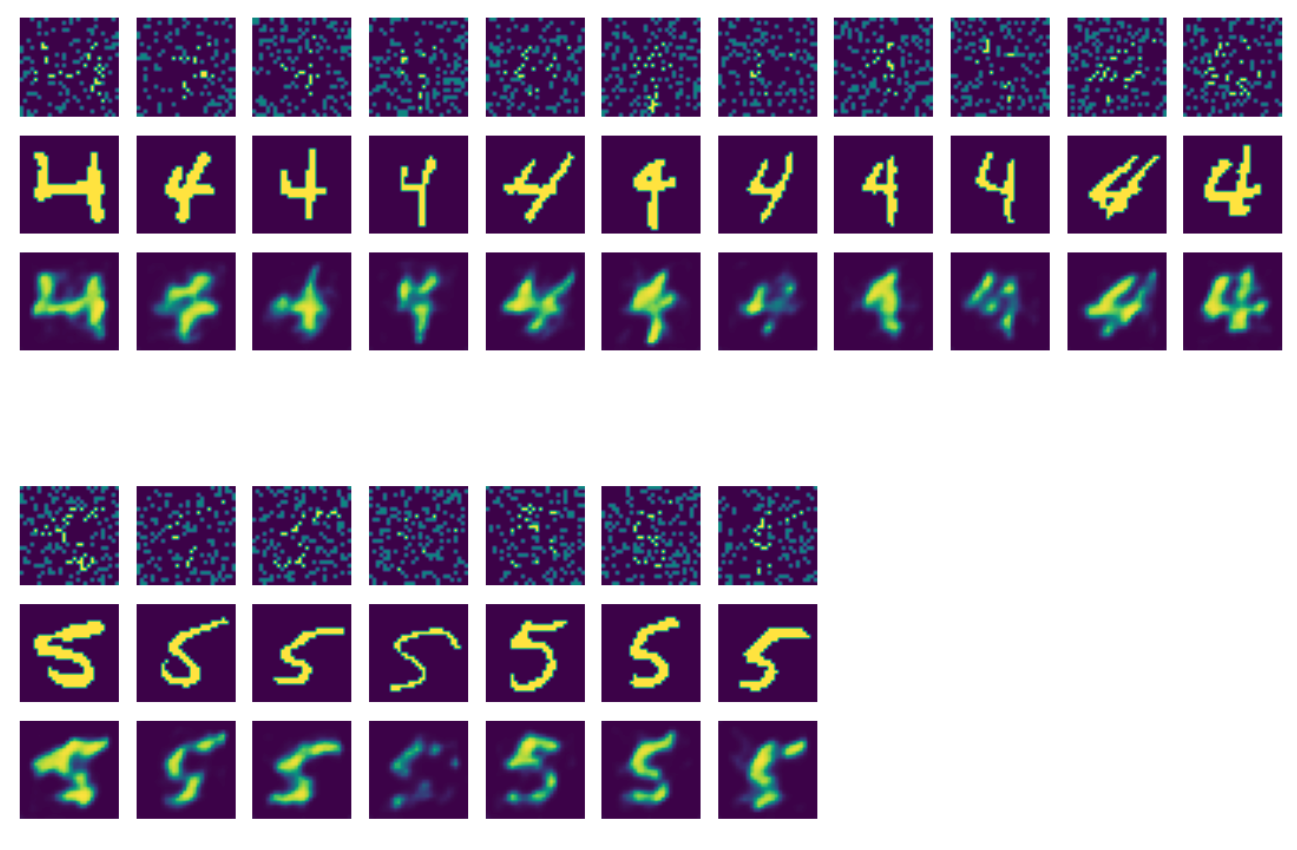

In [ ]:
def plot_XY2_pred(X,Y,Y_pred):
    nb_i=len(X)
    nb_j=max([x.shape[0] for x in X])
    fig,axs=plt.subplots(nb_i*4,nb_j,figsize=(nb_j,nb_i*4))
    for i in range(nb_i*4):
        for j in range(nb_j):
            axs[i,j].axis("off")

    for i in range(nb_i):
        x=X[i]
        y=Y[i]
        y_pred=Y_pred[i]
        for j in range(x.shape[0]):
            axs[4*i,j].imshow(x[j,:,:],vmin=0,vmax=2)
            axs[4*i+1,j].imshow(y[j,:,:],vmin=0,vmax=1)
            axs[4*i+2,j].imshow(y_pred[j,:,:],vmin=0,vmax=1)

    fig.tight_layout()

In [ ]:
X,Y=trainer.make_XY_test()
Y_pred=trainer.model(X)

In [ ]:
for i in range(5):
        x=X[i]
        y=Y[i]
        y_pred=Y_pred[i]
        print(x.shape,y.shape,y_pred.shape)

(7, 28, 28) (7, 28, 28) (7, 28, 28)
(12, 28, 28) (12, 28, 28) (12, 28, 28)
(10, 28, 28) (10, 28, 28) (10, 28, 28)
(9, 28, 28) (9, 28, 28) (9, 28, 28)
(8, 28, 28) (8, 28, 28) (8, 28, 28)


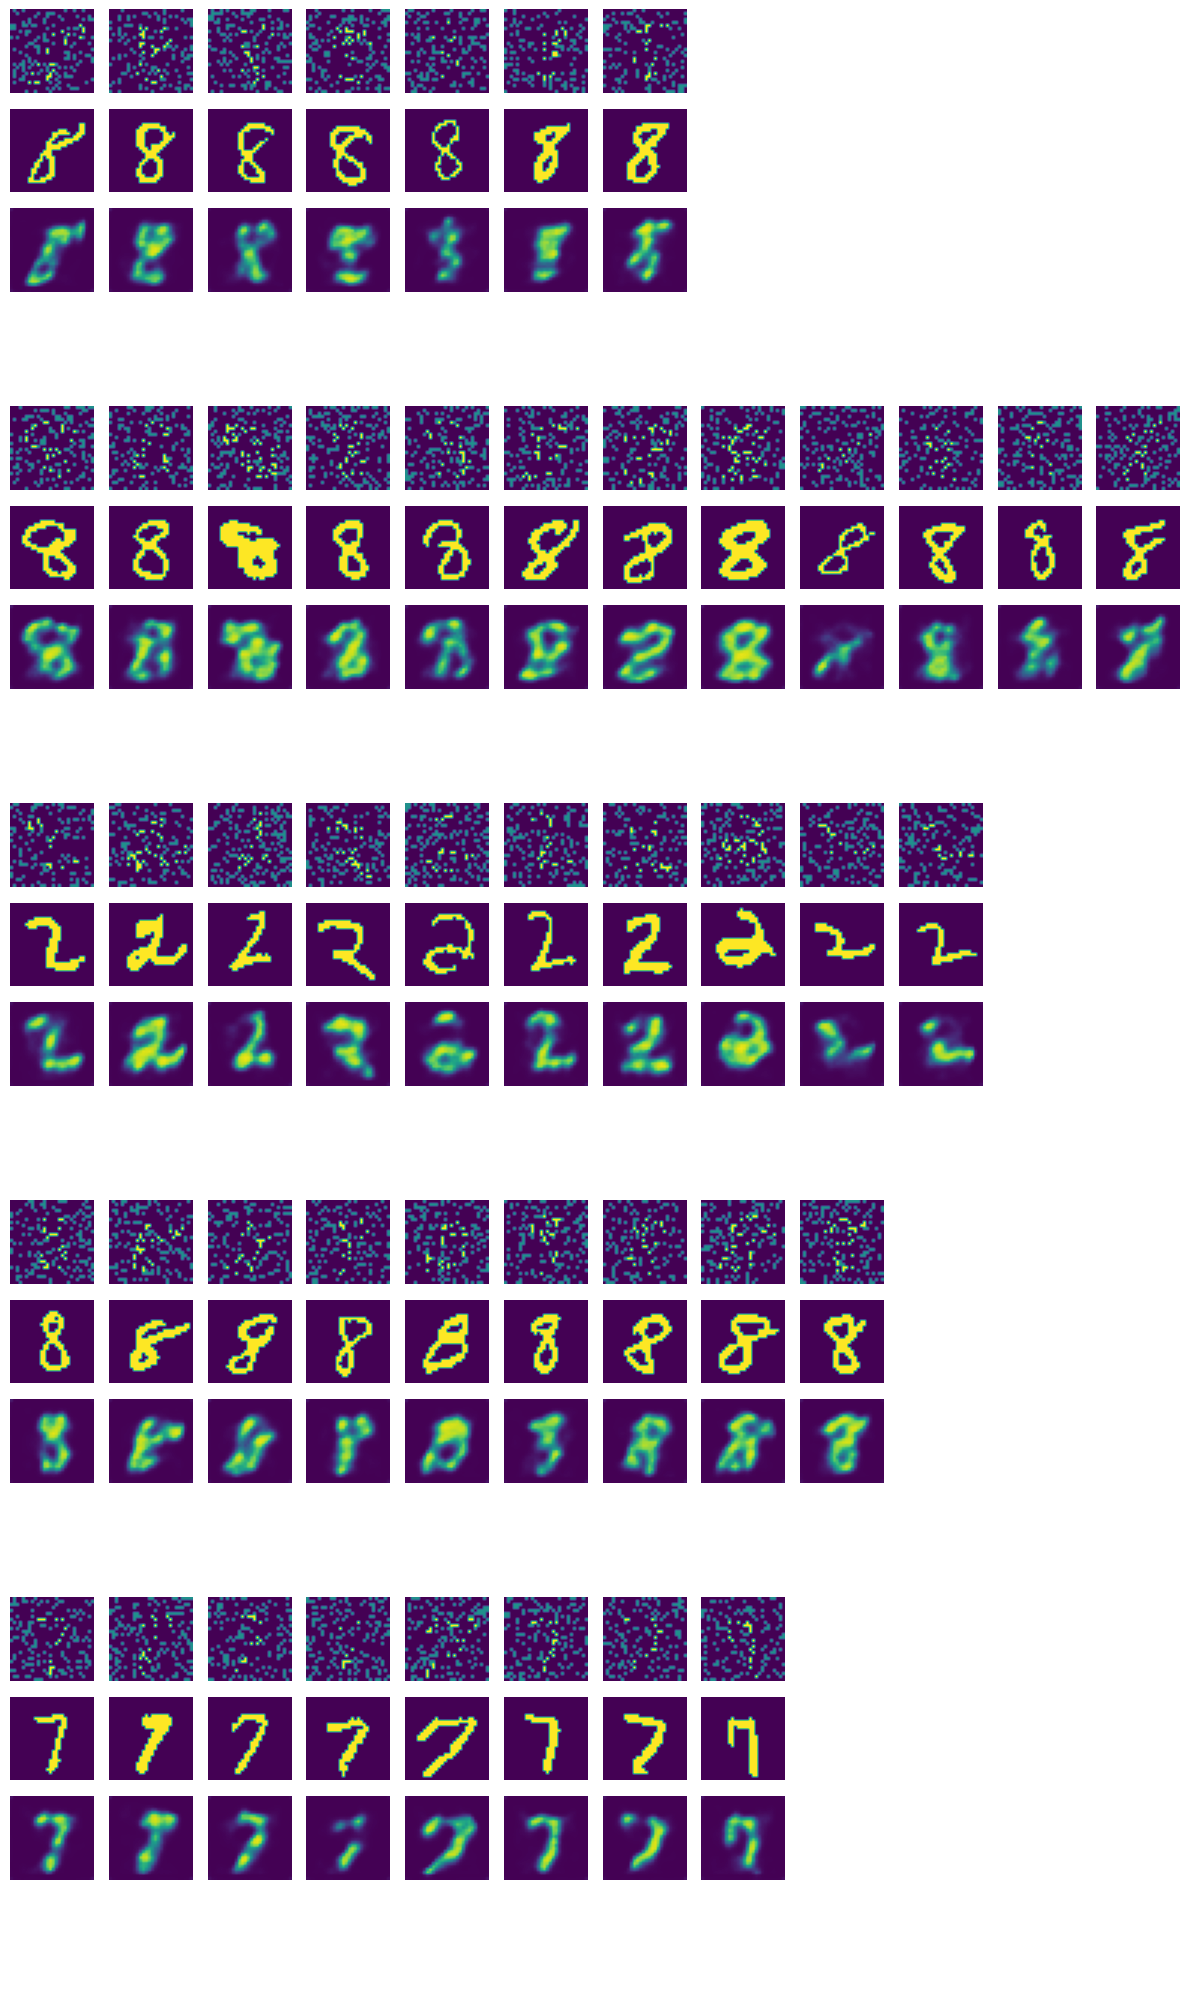

In [ ]:
plot_XY2_pred(X[:5],Y[:5],Y_pred[:5])